In [1]:
import os

import pandas as pd

import numpy as np
from numpy import random

from random import sample

import matplotlib.pyplot as plt

import skimage
from skimage import io
from skimage.feature import daisy, hog, ORB, local_binary_pattern, SIFT
from skimage.color import label2rgb, rgb2gray
from skimage.transform import resize, rotate, downscale_local_mean

from scipy import ndimage as ndi
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from skimage import exposure

# from tqdm import tqdm

import gc

from joblib import Parallel, delayed

from tqdm.notebook import tqdm

from sklearn.preprocessing import Normalizer
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

from scipy.special import erfcinv

In [2]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv')

In [3]:
# gabor filter

def createGaborfilterbank(m=39, n=39):
    garray = []
    fmax = 0.327 # maximum frequency
    gamma = np.sqrt(2)
    eta = np.sqrt(2)
    
    gamma = 0.5
    eta = 0.5
    
    u = 6 #number of frequencies
    v = 8 #number of orientation

    for i in range(0,u):

        fu = fmax/np.sqrt(2)**(i); # frequency
        alpha = fu/gamma;
        beta = fu/eta;

        for j in range(0,v):
            theta = j/v*np.pi; # orientation 

            x, y = np.meshgrid(np.arange(1,n+1,1), np.arange(1,m+1,1))

            xenvolope  =  (x-((m+1)/2))*np.cos(theta) + (y-((n+1)/2))*np.sin(theta);
            yenvolope  = -(x-((m+1)/2))*np.sin(theta) + (y-((n+1)/2))*np.cos(theta);
            
            gfilter = np.transpose(
                                (fu**2/(np.pi*gamma*eta))*np.exp(-((alpha**2)*(xenvolope**2) + 
                              (beta**2)*(yenvolope**2)))*np.exp(1j*2*np.pi*fu*xenvolope)
                                    );

            garray.append(gfilter);

    plt.figure(figsize=(15,10))

    for i in range(48):    
        ax = plt.subplot(6,8,i+1)
        # ax.set_title(label)
        plt.imshow(np.real(garray[i]),cmap='Greys_r')
        plt.axis("off")  
        
    return garray

def computeGaborfeatures(image, kernels):
    feats = []
    filteredimg = []
    
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, np.abs(kernel), mode='wrap')
            
        feats.append(filtered.mean())
        feats.append(filtered.std())
        
        filteredimg.append(filtered)
        
    return feats, filteredimg

In [4]:
def norminv(p,mu,sigma):
    
    x0 = np.multiply(-np.sqrt(2),(erfcinv(2*p)));
    x = np.multiply(sigma, x0) + mu;
    
    return x

In [6]:
def ellipsoid_envelope_point(a,b,c):

    x=(c*(a**2))/np.sqrt(b**2+c**2*a**2)
    y=b/a*np.sqrt(a**2-x**2);
    
    return np.array([x,y])

In [127]:
def accurate_envelope_f(f0,a,b,theta):

    if np.mod(theta, np.pi/2)!=0:

        # solve points with slopes -tan(pi/2-theta) and tan(theta)
        x1y1 = ellipsoid_envelope_point(a,b,-np.tan(np.pi/2-theta))
        x2y2 = ellipsoid_envelope_point(a,b,np.tan(theta))
        
        envelope = np.array([x1y1, -x1y1, x2y2, -x2y2])
    
        # shift by f0
        envelope = envelope + np.tile([f0, 0],[4,1])

        # rotate by theta
        envelope = np.matmul(envelope, np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]]))

        xmin = min(envelope[:,0]);
        xmax = max(envelope[:,0]);
        ymin = min(envelope[:,1]);
        ymax = max(envelope[:,1]);

        envelope=np.real([xmin, xmax, ymin, ymax])

    else: 

        envelope = np.array([[f0-a, 0], [f0+a, 0] , [f0, b], [f0, -b]])
        
        envelope = np.matmul(envelope, np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]]))
        
        xmin = min(envelope[:,0]);
        xmax = max(envelope[:,0]);
        ymin = min(envelope[:,1]);
        ymax = max(envelope[:,1]);
        
        envelope=np.real([xmin, xmax, ymin, ymax])

    return envelope
    

In [118]:
def computeAGaborFilter(f0, theta, gamma, eta, Nx, Ny):
    
    pf = np.sqrt(0.99)
    alpha = f0/gamma;
    beta = f0/eta;
    
    # accurate rectangular envelope
    majenv = norminv(np.array([1-pf, 1+pf])/2,0,f0/(np.sqrt(2)*np.pi*gamma));
    minenv = norminv(np.array([1-pf, 1+pf])/2,0,f0/(np.sqrt(2)*np.pi*eta));
    
    envelope=accurate_envelope_f(f0,majenv[1],minenv[1],theta);
    
    envelope[:2] = envelope[:2]*Nx
    envelope[-2:] = envelope[-2:]*Ny
    
    envelope = np.array([np.floor(envelope[0]), np.ceil(envelope[1]), np.floor(envelope[2]), np.ceil(envelope[3])]);
    
    nx = np.arange(envelope[0]-1, envelope[1], 1, dtype=int)
    ny = np.arange(envelope[2]-1, envelope[3], 1, dtype=int)
    
    u = nx/Nx; #frequencies that bank contains
    v = ny/Ny;
    
    U, V = np.meshgrid(u,v)
    
    Uenvelope =  (np.add(-U * np.sin(theta), V * np.cos(theta)))**2/(beta**2)
    Venvelope =  (np.add(U * np.cos(theta), V * np.sin(theta)-f0))**2/alpha**2
    
    gf = np.exp(-(np.pi**2) * np.add(Uenvelope,Venvelope))
    
    return gf
    

In [140]:
def createSetOfGarborFilters(m=43, n=43):
    garray = []
    
    fmax = 0.327 # maximum frequency

    k = np.sqrt(2) #frequency ratio or factor for selecting filter frequencies
    
    gamma = 0.5 #smoothing parameter gamma
    eta = 0.5 #smoothing parameter eta
    
    pf = np.sqrt(0.99) #energy to include in the filters
    
    u = 6 #number of frequencies
    v = 8 #number of orientation

    for i in range(0,u):

        fu = fmax/k**i; # frequency of the filter

        for j in range(0,v):
            theta = j/v*np.pi; # orientation of the filter 
            
            gaborfilter = computeAGaborFilter(fu, theta, gamma, eta, m, n) 

            garray.append(gaborfilter);
        
    return garray

In [141]:
garray = createSetOfGarborFilters(m=43, n=43)

In [145]:
str(garray[0].shape)

'(37, 37)'

<Figure size 1500x1000 with 0 Axes>

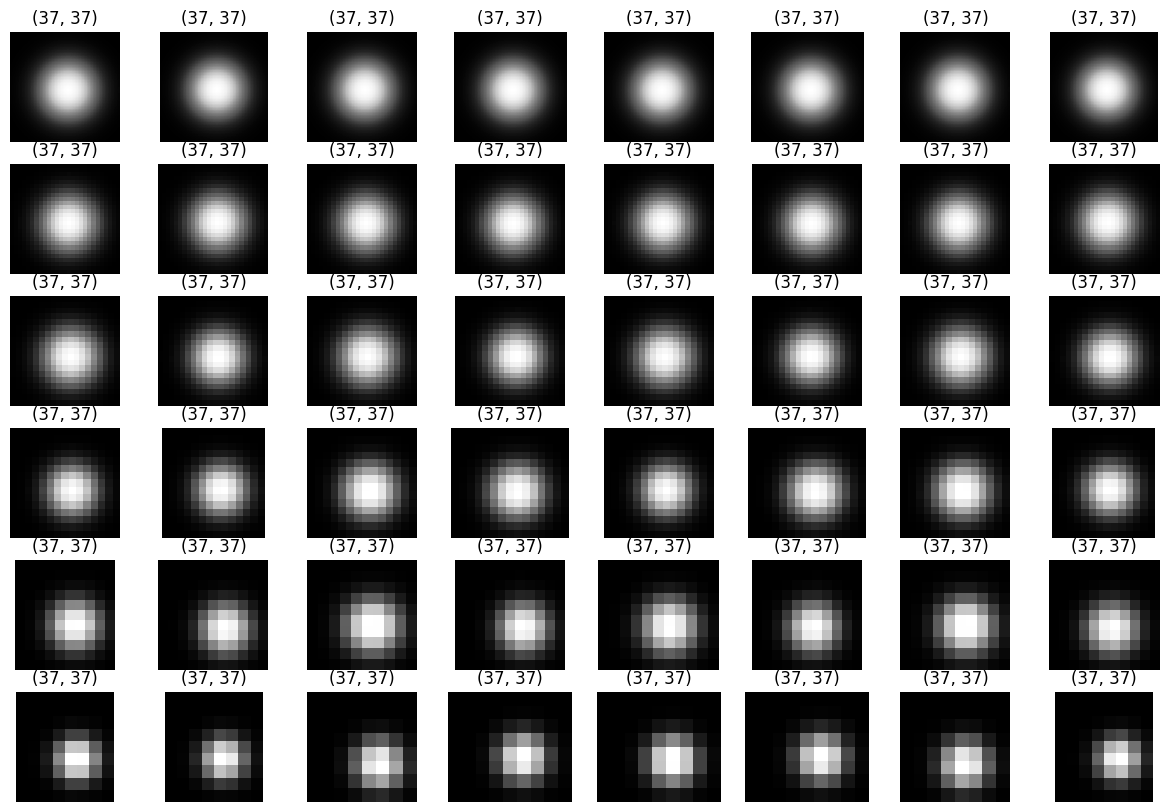

<Figure size 1500x1000 with 0 Axes>

In [146]:
plt.figure(figsize=(15,10))
for i in range(48):    
    ax = plt.subplot(6,8,i+1)
    # ax.set_title(label)
    plt.imshow((garray[i]),cmap='Greys_r')
    label = str(garray[0].shape)
    ax.set_title(label)
    plt.axis("off") 
    
plt.figure(figsize=(15,10))

In [154]:
img = io.imread(dfFoldTraining_1["filenames"][10000])
feartures, imgfiltered = computeGaborfeatures(img_as_float(img), garray)

(-0.5, 183.5, 183.5, -0.5)

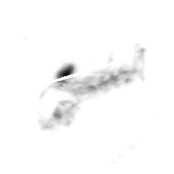

In [155]:
plt.figure(figsize=(5,2))

plt.imshow(img,cmap='Greys_r')

plt.axis("off") 
    


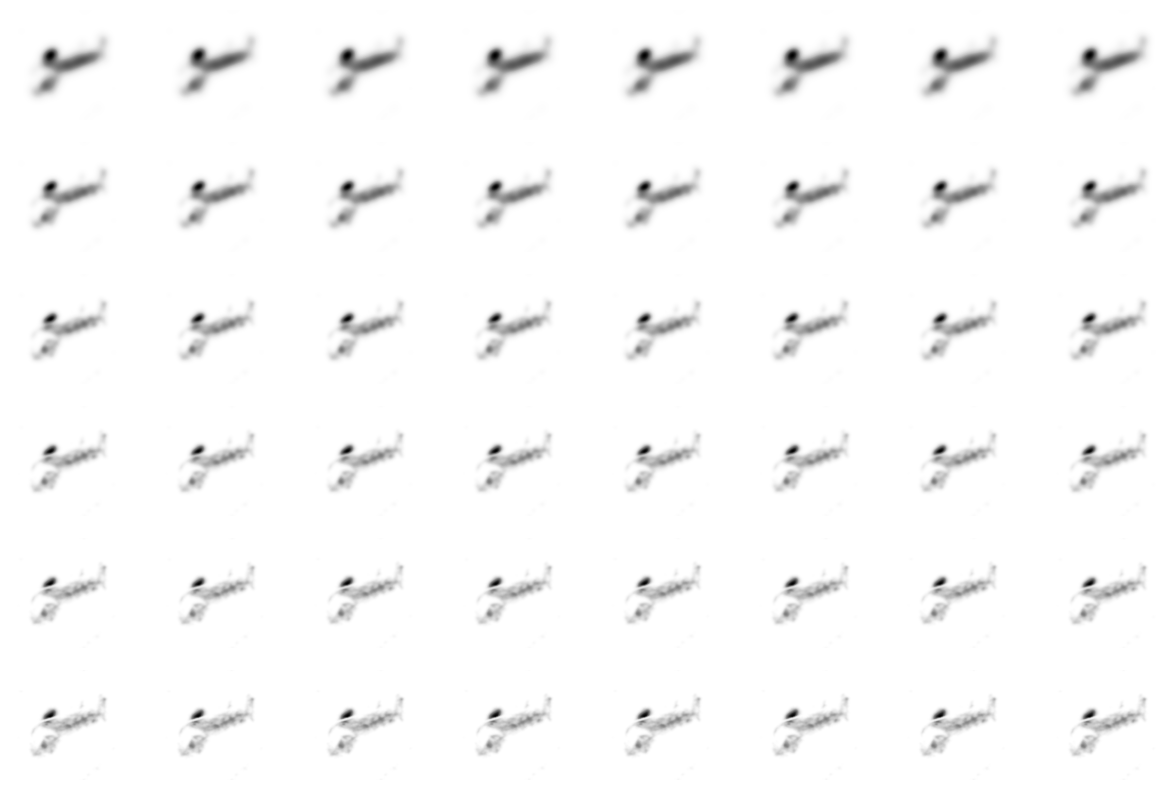

In [156]:
plt.figure(figsize=(15,10))
for i in range(48):    
    ax = plt.subplot(6,8,i+1)
    # ax.set_title(label)
    plt.imshow(imgfiltered[i],cmap='Greys_r')

    plt.axis("off") 

In [134]:
for i in range(0,6):
    fu = 0.327/np.sqrt(2)**i; # frequency
    alpha = fu/gamma;
    beta = fu/eta;
    
    display(fu)

0.327

0.23122391744800103

0.16349999999999998

0.1156119587240005

0.08174999999999999

0.05780597936200024

In [123]:
f0=0.327
gamma=eta=0.5
beta=alpha=0.654
theta=0.3927
Nx=43;
Ny=43;
pf=np.sqrt(0.99);

In [124]:
# accurate rectangular envelope
majenv=norminv(np.array([1-pf, 1+pf])/2,0,f0/(np.sqrt(2)*np.pi*gamma));

minenv=norminv(np.array([1-pf, 1+pf])/2,0,f0/(np.sqrt(2)*np.pi*eta));

display(majenv)
display(minenv)

array([-0.41308119,  0.41308119])

array([-0.41308119,  0.41308119])

In [128]:
envelope=accurate_envelope_f(f0,majenv[1],minenv[1],theta);

display(envelope)

array([-0.11097269,  0.71518968, -0.28794343,  0.53821895])

In [56]:
envelope[:2] = envelope[:2]*Nx
envelope[-2:] = envelope[-2:]*Ny

display(envelope)

array([ -3.70149102,  31.82349102, -17.76249102,  17.76249102])

In [59]:
np.array([np.floor(envelope[0]), np.ceil(envelope[1]), np.floor(envelope[2]), np.ceil(envelope[3])])

array([ -4.,  32., -18.,  18.])

In [71]:
np.arange(envelope[0]-1, envelope[1], 1, dtype=int)

array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 31, 32])

In [72]:
np.arange(envelope[0]-1, envelope[1], 1, dtype=int)/43

array([-0.09302326, -0.06976744, -0.04651163, -0.02325581,  0.        ,
        0.02325581,  0.04651163,  0.06976744,  0.09302326,  0.11627907,
        0.13953488,  0.1627907 ,  0.18604651,  0.20930233,  0.23255814,
        0.25581395,  0.27906977,  0.30232558,  0.3255814 ,  0.34883721,
        0.37209302,  0.39534884,  0.41860465,  0.44186047,  0.46511628,
        0.48837209,  0.51162791,  0.53488372,  0.55813953,  0.58139535,
        0.60465116,  0.62790698,  0.65116279,  0.6744186 ,  0.69767442,
        0.72093023,  0.74418605])

In [95]:
nx = np.arange(envelope[0]-1, envelope[1], 1, dtype=int)
ny = np.arange(envelope[2]-1, envelope[3], 1, dtype=int)

u = nx/Nx; #frequencies that bank contains
v = ny/Ny;

display(u,v)

array([-0.09302326, -0.06976744, -0.04651163, -0.02325581,  0.        ,
        0.02325581,  0.04651163,  0.06976744,  0.09302326,  0.11627907,
        0.13953488,  0.1627907 ,  0.18604651,  0.20930233,  0.23255814,
        0.25581395,  0.27906977,  0.30232558,  0.3255814 ,  0.34883721,
        0.37209302,  0.39534884,  0.41860465,  0.44186047,  0.46511628,
        0.48837209,  0.51162791,  0.53488372,  0.55813953,  0.58139535,
        0.60465116,  0.62790698,  0.65116279,  0.6744186 ,  0.69767442,
        0.72093023,  0.74418605])

array([-0.41860465, -0.39534884, -0.37209302, -0.34883721, -0.3255814 ,
       -0.30232558, -0.27906977, -0.25581395, -0.23255814, -0.20930233,
       -0.18604651, -0.1627907 , -0.13953488, -0.11627907, -0.09302326,
       -0.06976744, -0.04651163, -0.02325581,  0.        ,  0.02325581,
        0.04651163,  0.06976744,  0.09302326,  0.11627907,  0.13953488,
        0.1627907 ,  0.18604651,  0.20930233,  0.23255814,  0.25581395,
        0.27906977,  0.30232558,  0.3255814 ,  0.34883721,  0.37209302,
        0.39534884,  0.41860465])

In [96]:
U,V=np.meshgrid(u,v);
display(U.shape, V.shape)

(37, 37)

(37, 37)

In [97]:
U

array([[-0.09302326, -0.06976744, -0.04651163, ...,  0.69767442,
         0.72093023,  0.74418605],
       [-0.09302326, -0.06976744, -0.04651163, ...,  0.69767442,
         0.72093023,  0.74418605],
       [-0.09302326, -0.06976744, -0.04651163, ...,  0.69767442,
         0.72093023,  0.74418605],
       ...,
       [-0.09302326, -0.06976744, -0.04651163, ...,  0.69767442,
         0.72093023,  0.74418605],
       [-0.09302326, -0.06976744, -0.04651163, ...,  0.69767442,
         0.72093023,  0.74418605],
       [-0.09302326, -0.06976744, -0.04651163, ...,  0.69767442,
         0.72093023,  0.74418605]])

In [98]:
V

array([[-0.41860465, -0.41860465, -0.41860465, ..., -0.41860465,
        -0.41860465, -0.41860465],
       [-0.39534884, -0.39534884, -0.39534884, ..., -0.39534884,
        -0.39534884, -0.39534884],
       [-0.37209302, -0.37209302, -0.37209302, ..., -0.37209302,
        -0.37209302, -0.37209302],
       ...,
       [ 0.37209302,  0.37209302,  0.37209302, ...,  0.37209302,
         0.37209302,  0.37209302],
       [ 0.39534884,  0.39534884,  0.39534884, ...,  0.39534884,
         0.39534884,  0.39534884],
       [ 0.41860465,  0.41860465,  0.41860465, ...,  0.41860465,
         0.41860465,  0.41860465]])

In [107]:
Uenvelope =  (np.add(-U * np.sin(theta), V * np.cos(theta)))**2/(beta**2)
Venvelope =  (np.add(U * np.cos(theta), V * np.sin(theta)-f0))**2/alpha**2

In [112]:
gf=np.exp(-(np.pi**2) * np.add(Uenvelope,Venvelope))

In [117]:
gf[34,1]

0.0010836546480005999

In [100]:
V

array([[-0.41860465, -0.41860465, -0.41860465, ..., -0.41860465,
        -0.41860465, -0.41860465],
       [-0.39534884, -0.39534884, -0.39534884, ..., -0.39534884,
        -0.39534884, -0.39534884],
       [-0.37209302, -0.37209302, -0.37209302, ..., -0.37209302,
        -0.37209302, -0.37209302],
       ...,
       [ 0.37209302,  0.37209302,  0.37209302, ...,  0.37209302,
         0.37209302,  0.37209302],
       [ 0.39534884,  0.39534884,  0.39534884, ...,  0.39534884,
         0.39534884,  0.39534884],
       [ 0.41860465,  0.41860465,  0.41860465, ...,  0.41860465,
         0.41860465,  0.41860465]])

In [105]:
(np.add(-U * np.sin(theta), V * np.cos(theta)))**2/(beta**2)

array([[0.4096874 , 0.4096874 , 0.4096874 , ..., 0.4096874 , 0.4096874 ,
        0.4096874 ],
       [0.36543104, 0.36543104, 0.36543104, ..., 0.36543104, 0.36543104,
        0.36543104],
       [0.32370362, 0.32370362, 0.32370362, ..., 0.32370362, 0.32370362,
        0.32370362],
       ...,
       [0.32370362, 0.32370362, 0.32370362, ..., 0.32370362, 0.32370362,
        0.32370362],
       [0.36543104, 0.36543104, 0.36543104, ..., 0.36543104, 0.36543104,
        0.36543104],
       [0.4096874 , 0.4096874 , 0.4096874 , ..., 0.4096874 , 0.4096874 ,
        0.4096874 ]])

In [106]:
np.add(U * np.cos(theta), V * np.sin(theta)-f0)**2/alpha**2

array([[0.41246887, 0.36805825, 0.32617657, ..., 0.32124009, 0.36281324,
        0.40691533],
       [0.41246887, 0.36805825, 0.32617657, ..., 0.32124009, 0.36281324,
        0.40691533],
       [0.41246887, 0.36805825, 0.32617657, ..., 0.32124009, 0.36281324,
        0.40691533],
       ...,
       [0.41246887, 0.36805825, 0.32617657, ..., 0.32124009, 0.36281324,
        0.40691533],
       [0.41246887, 0.36805825, 0.32617657, ..., 0.32124009, 0.36281324,
        0.40691533],
       [0.41246887, 0.36805825, 0.32617657, ..., 0.32124009, 0.36281324,
        0.40691533]])

In [33]:
a=majenv[1]
b=minenv[1]
display(f0,a,b)

0.327

0.4130811865519662

0.4130811865519662

In [72]:
f0-a

-0.08608118655196617

In [34]:
envelope = np.array([[f0-a, 0], [f0+a, 0],[f0, b],[f0, -b]])
display(envelope, envelope.shape)

array([[-0.08608119,  0.        ],
       [ 0.74008119,  0.        ],
       [ 0.327     ,  0.41308119],
       [ 0.327     , -0.41308119]])

(4, 2)

In [35]:
ccc=np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])
display(ccc, ccc.shape)

array([[ 1.,  0.],
       [-0.,  1.]])

(2, 2)

In [37]:
envelope=np.matmul(envelope, ccc)
display(envelope)

array([[-0.08608119,  0.        ],
       [ 0.74008119,  0.        ],
       [ 0.327     ,  0.41308119],
       [ 0.327     , -0.41308119]])

In [43]:
envelope[:,0]

array([-0.08608119,  0.74008119,  0.327     ,  0.327     ])

In [38]:
xmin = min(envelope[0,:]);
xmax = max(envelope[0,:]);
ymin = min(envelope[1,:]);
ymax = max(envelope[1,:]);
display(xmin, xmax, ymin, ymax)        

-0.08608118655196617

0.0

0.0

0.7400811865519662

In [48]:
envelope[:2]

array([-0.08608119,  0.74008119])

In [ ]:


envelope(1:2)=envelope(1:2)*N(2);
envelope(3:4)=envelope(3:4)*N(1);